# 1. GAN Implementation

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

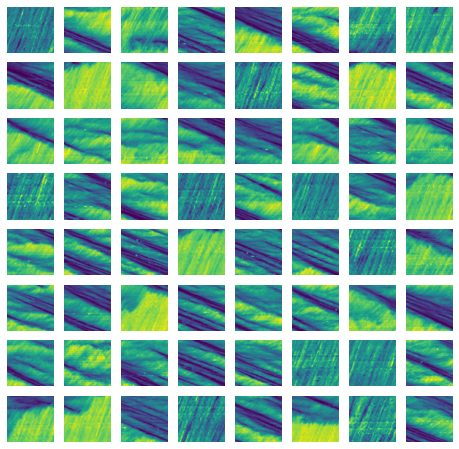

In [2]:
data = np.load('dataset/i24speedcontour_64.npy')
data = torch.tensor(data, dtype=torch.float32)
data = data.permute(0, 1, 3, 2)
data[data > 145] = 145

data_min = data.min()
data_max = data.max()

data = (data - data_min) / (data_max - data_min)

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(data[np.random.randint(data.shape[0])][0], origin="lower" )
        ax[i, j].axis("off")

In [3]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

![alt text](img/GAN_edit.png "Title")

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen_fc = nn.Sequential(
            nn.Linear(z_dim, 128 * 8 * 8),
            nn.ReLU(True)
        )
        self.gen_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 4, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.gen_fc(x)
        x = x.view(x.size(0), 128, 8, 8)
        x = self.gen_conv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc_conv = nn.Sequential(
            nn.Conv2d(4, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.disc_fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.disc_conv(x)
        x = x.view(x.size(0), -1)
        x = self.disc_fc(x)
        return x

In [5]:
# Hyperparameters
z_dim = 64  # Size of the noise vector
lr = 0.0002
beta1 = 0.5

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optim_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

The learning process is guided by a value function $V(\phi, \theta)$, defined as follows:

- $V(\phi, \theta) = \mathbb{E}_{\mathbf{x} \sim p_{data}(\mathbf{x})}[\log D_{\phi}(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})}[\log(1 - D_{\phi}(G_{\theta}(\mathbf{z})))]$

The learning process involves simultaneously optimizing the parameters of both $G$ and $D$, specifically $\theta$ and $\phi$, through gradient-based methods as shown below. This process alternates between the following two steps:
 

- $ Goal: \phi^{*},\theta^{*} = \min_{G_{\theta}} \max_{G_{\phi}} V(\phi, \theta)$

In [7]:
# Training loop
num_epochs = 50
real_label = 1.0
fake_label = 0.0

for epoch in range(num_epochs):
    running_loss_D = 0.0
    running_loss_G = 0.0
    for i, data in enumerate(train_loader, 0):
        # Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with real batch
        discriminator.zero_grad()
        real_data = data.to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), real_label, device=device).float()
        
        output = discriminator(real_data).view(-1)
        # errD_real = -[y_i * log(D(x_i))] where y_i=1 for real
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(batch_size, z_dim, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        # errD_fake = -[(1 - y_i) * log(1 - D(G(z_i)))] where y_i=0 for fake
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optim_disc.step()
        
        running_loss_D += errD.item()*batch_size

        # Update Generator: maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = discriminator(fake).view(-1)
        # errG = -[y_i * log(D(G(z_i)))] where y_i=1 for real
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optim_gen.step()
        
        running_loss_G += errG.item()*batch_size

    # Print averaged loss per epoch
    avg_loss_D = running_loss_D / train_size
    avg_loss_G = running_loss_G / train_size
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss_D: {avg_loss_D:.4f} Loss_G: {avg_loss_G:.4f}')

# Save the model after training
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
print("Generator and Discriminator models saved.")

Epoch [1/50] Loss_D: 0.5213 Loss_G: 2.8507
Epoch [2/50] Loss_D: 0.4444 Loss_G: 2.9140
Epoch [3/50] Loss_D: 0.4013 Loss_G: 2.9011
Epoch [4/50] Loss_D: 0.3806 Loss_G: 2.8279
Epoch [5/50] Loss_D: 0.3838 Loss_G: 2.8877
Epoch [6/50] Loss_D: 0.7818 Loss_G: 2.8400
Epoch [7/50] Loss_D: 0.3346 Loss_G: 2.6356
Epoch [8/50] Loss_D: 0.6801 Loss_G: 2.9647
Epoch [9/50] Loss_D: 0.3631 Loss_G: 2.6224
Epoch [10/50] Loss_D: 0.3901 Loss_G: 2.7479
Epoch [11/50] Loss_D: 0.4913 Loss_G: 2.8801
Epoch [12/50] Loss_D: 0.3752 Loss_G: 2.9031
Epoch [13/50] Loss_D: 0.6765 Loss_G: 2.8469
Epoch [14/50] Loss_D: 0.3355 Loss_G: 2.8519
Epoch [15/50] Loss_D: 0.3883 Loss_G: 2.9576
Epoch [16/50] Loss_D: 0.8280 Loss_G: 2.7076
Epoch [17/50] Loss_D: 0.3658 Loss_G: 2.6850
Epoch [18/50] Loss_D: 0.3742 Loss_G: 2.7944
Epoch [19/50] Loss_D: 0.3483 Loss_G: 2.8245
Epoch [20/50] Loss_D: 0.4115 Loss_G: 3.0416
Epoch [21/50] Loss_D: 1.0173 Loss_G: 2.9035
Epoch [22/50] Loss_D: 0.3632 Loss_G: 2.5943
Epoch [23/50] Loss_D: 0.3611 Loss_G: 2.77

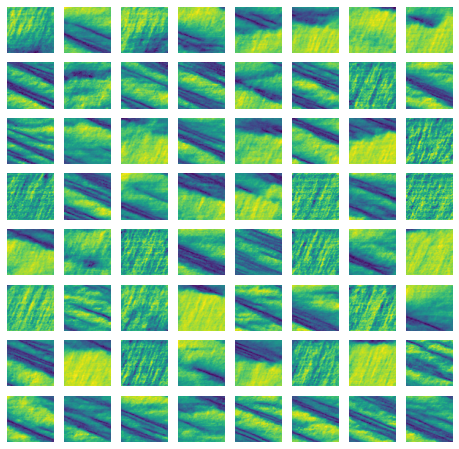

In [17]:
z_dim = 64

device = "cpu"

model = Generator(z_dim).to(device)
model.load_state_dict(torch.load('generator.pth', map_location="cpu"))
model.eval()

# Sample from the latent space
with torch.no_grad():
    z = torch.randn(64, z_dim).to(device)
    sample = model(z).cpu()
    sample = sample.numpy()

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(sample[i * 8 + j][0,:,:], origin="lower")
        ax[i, j].axis("off")
plt.show()